# Exercise 7
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-12: v.1.0. First public release. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import spsolve

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

## 3. Kernelized Ridge Regression (10 pts)

In [2]:
def squared_exp_kernel(X1, X2, sigma, tau=None):
    '''
    Calculate the squared exponential kernel function 
    for feature set X1 and X2. 
    
    Parameters:
    -----------
    X1: np.array shape=(M,D)
        First feature set, M instances of D dimensions.
    X2: np.array shape=(N,D)
        Second feature set, N instances of D dimensions.
    sigma: float
        Standard deviation of the gaussian distribution.
    tau: float
        (Optional) regularization parameter.
    
    Returns:
    --------
    scipy.sparse.coo_matrix  shape=(M,N)
        Resulting kernel matrix of feature sets X1 and X2.
    '''
    # Get matrix shapes, assure compatible sizes. 
    M,D  = X1.shape
    N,D2 = X2.shape
    assert D == D2
    
    # To reduce RAM-requirements, we chose a list-based methods of saving 
    # interesting pixel pairs, instead of explicitly forming the full matrix 
    # with distances from all instances in X1 to all instances in X2.
    d1 = []; ix = []; iy = []
    
    # For each instance in X2, do 
    for i in range(N):        
        # Calculate squared distances from X2[i] to all instances in X1.
        dist = np.sqrt(np.sum((X1-X2[i])**2, axis=1)) # shape = (M,)
        
        # Filter out distant pixel pairs.
        mask = dist < 3*sigma
        
        # Append to lists.
        d1.append(dist[mask].astype('float32'))               # L2 distance
        ix.append(mask.nonzero()[0].astype('int32'))          # Index in x
        iy.append(i*np.ones_like(dist[mask]).astype('int32')) # Index in y
    
    # Concatenate to single vectors.
    dist = np.concatenate(d1)
    ix   = np.concatenate(ix)
    iy   = np.concatenate(iy)
        
    # Apply the gaussian functional form.
    weights = np.exp(-0.5*dist**2/sigma**2)
    
    # If regularization is chosen, add tau to the diagonal.
    if tau != None:
        weights += (ix == iy)*tau
    
    return coo_matrix((weights, (ix, iy)), shape=(M,N), dtype=np.float32)

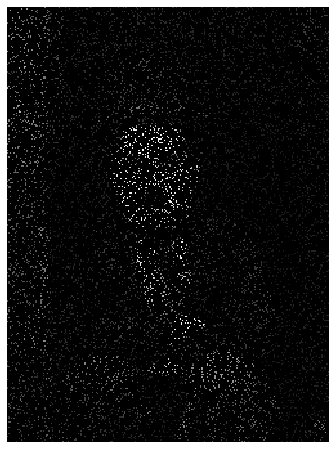

Shape: (338, 250)
Sparsity: 0.9


In [3]:
# Import the image.
im = plt.imread('cc_90.png')
plt.figure(figsize=(8,8))
plt.imshow(im)
plt.axis('off')
plt.show()

# Some info on the underlying sparse matrix.
im_shape = im.shape
print(f"Shape: {im_shape}")
print(f"Sparsity: {(im == 0).sum()/im.size}")

In [4]:
# Prepare the feature set, i.e. positions of the nonzero pixels.
(ix,iy) = im.nonzero()
X = np.array([ix,iy]).T
print(f'X.shape={X.shape}')

# Prepare the reponse vector, i.e. pixel values of non-zero pixels. 
y = im[ix,iy]
print(f'y.shape={y.shape}\n')

# Prepare the feature set of the missing pixels values.
(ix_zero, iy_zero) = (im == 0).nonzero()
X_new = np.array([ix_zero, iy_zero]).T
print(f'X_new.shape={X_new.shape}\n')

X.shape=(8450, 2)
y.shape=(8450,)

X_new.shape=(76050, 2)



In [5]:
def kernal_ridge_regression(X_new, X, y, sigma, tau):
    """
    
    """
    # Get the kernel matrix, with regularization.
    G_tau = squared_exp_kernel(X,X,sigma=sigma,tau=tau)
    
    # Convert to CSC sparse matrix format.
    G_tau = G_tau.tocsc()
    
    # Solve for the weight vector alpha.
    alpha = spsolve(G_tau, y)
    
    # Get kernel matrix for new instances X_new.
    kappa = squared_exp_kernel(X_new, X, sigma=sigma)
    
    # Calculate predicted responses.
    y_new = kappa.dot(alpha)
    
    # Re-construct image
    img = np.zeros(im_shape)
    img[X[:,0],X[:,1]]         = y      # original pixels
    img[X_new[:,0],X_new[:,1]] = y_new  # predicted pixels
    
    return img

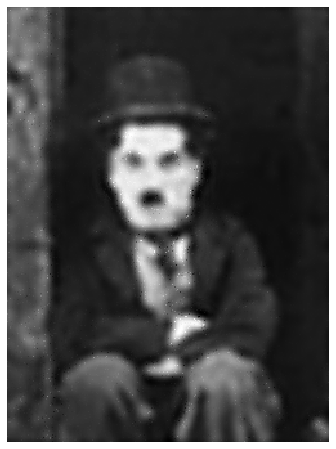

In [6]:
# Parameters
sigma = 5
tau   = 0.4

# Recontruct using Kernal Ridge Regression
img = kernal_ridge_regression(X_new, X, y, sigma, tau)

# Plot the result
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.show()

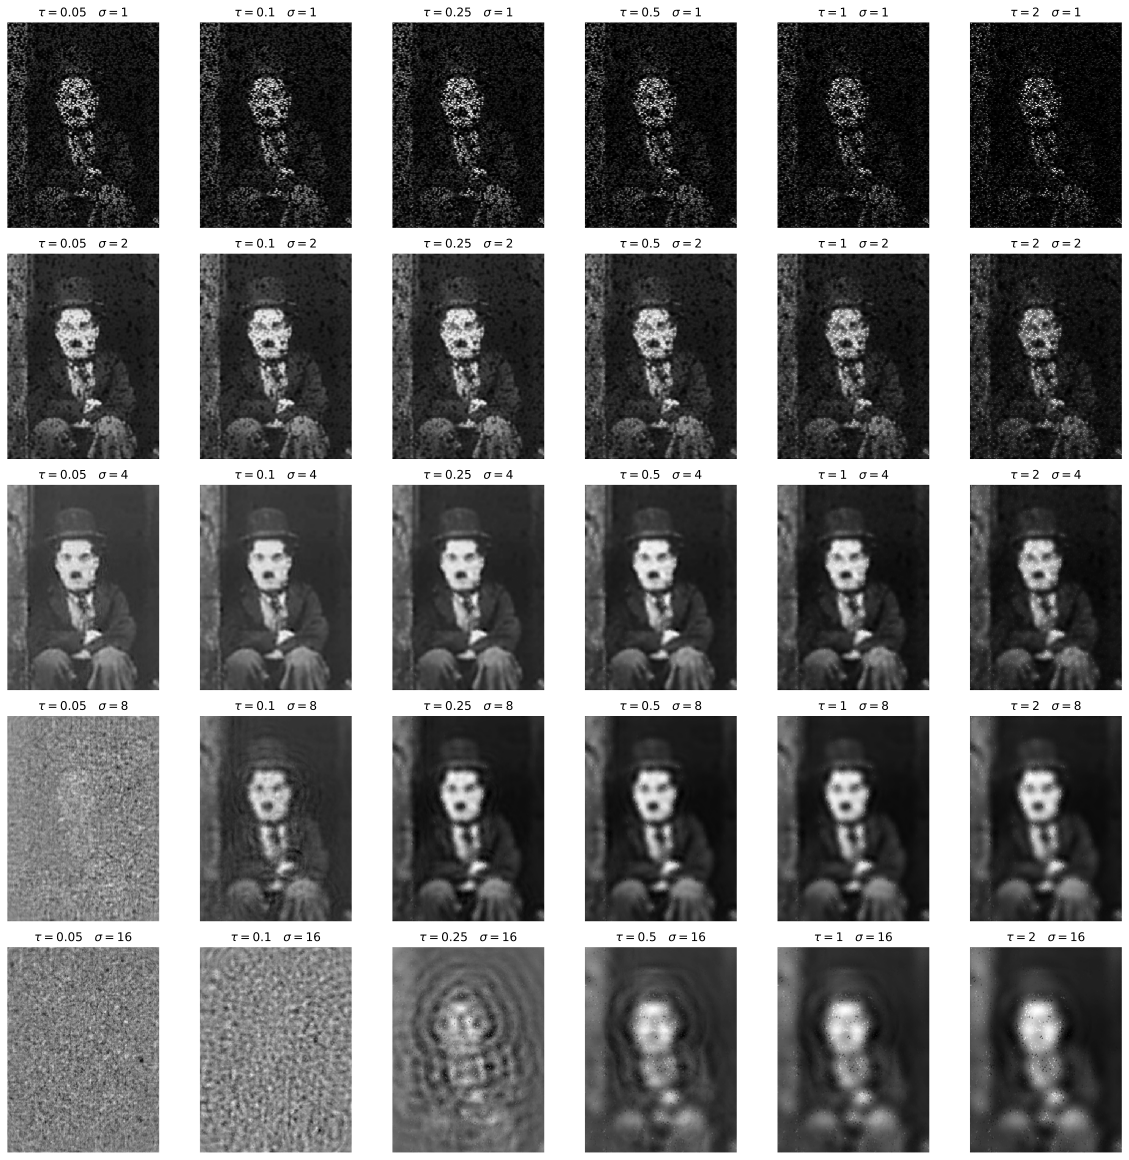

In [12]:
sigmas = [1, 2, 4, 8, 16]
taus   = [0.05, 0.1, 0.25, 0.5, 1, 2]

fsize = (16,16)
fig, ax = plt.subplots(len(sigmas), len(taus), figsize=fsize,constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()

for i, sigma in enumerate(sigmas):
    for j, tau in enumerate(taus):
        img = kernal_ridge_regression(X_new, X, y, sigma, tau)
        ax[i*len(taus)+j].imshow(img)
        ax[i*len(taus)+j].axis('off')
        ax[i*len(taus)+j].set_title(f'$\\tau={{{tau}}} \quad \sigma={{{sigma}}}$')
plt.show()